In [30]:
install.packages('timeSeries')


The downloaded binary packages are in
	/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T//RtmpgncYtU/downloaded_packages


In [72]:
# library(tidyverse)
# library(fpp3)
# library(tidyquant)
# library(sandwich)
# library(lmtest)
# library(GGally)
# library(kableExtra)

stock <- tidyquant::tq_get(c("^GSPC","^N225","^IXIC","^NYA"), 
   get = "stock.prices" ,from="1990-01-01", to="2021-12-31") %>% 
  mutate(symbol = ifelse(symbol == "^GSPC","S&P500",symbol)) %>% 
  mutate(symbol = ifelse(symbol == "^N225","Nikkei",symbol)) %>% 
  mutate(symbol = ifelse(symbol == "^IXIC","NASDAQ",symbol)) %>% 
  mutate(symbol = ifelse(symbol == "^NYA","NYSE",symbol)) %>% 
  mutate(date = as_date(date)) %>%
  as_tsibble(index = date,key = symbol) %>%
  group_by_key() %>% 
  mutate(rtn = difference(log(close))) %>% 
  filter(!is.na(rtn)) %>% 
  group_by_key() %>% 
  mutate(trading_day = row_number()) 
#stock %>% select(symbol,date,close,rtn)


`mutate_if()` ignored the following grouping variables:
• Column `symbol`


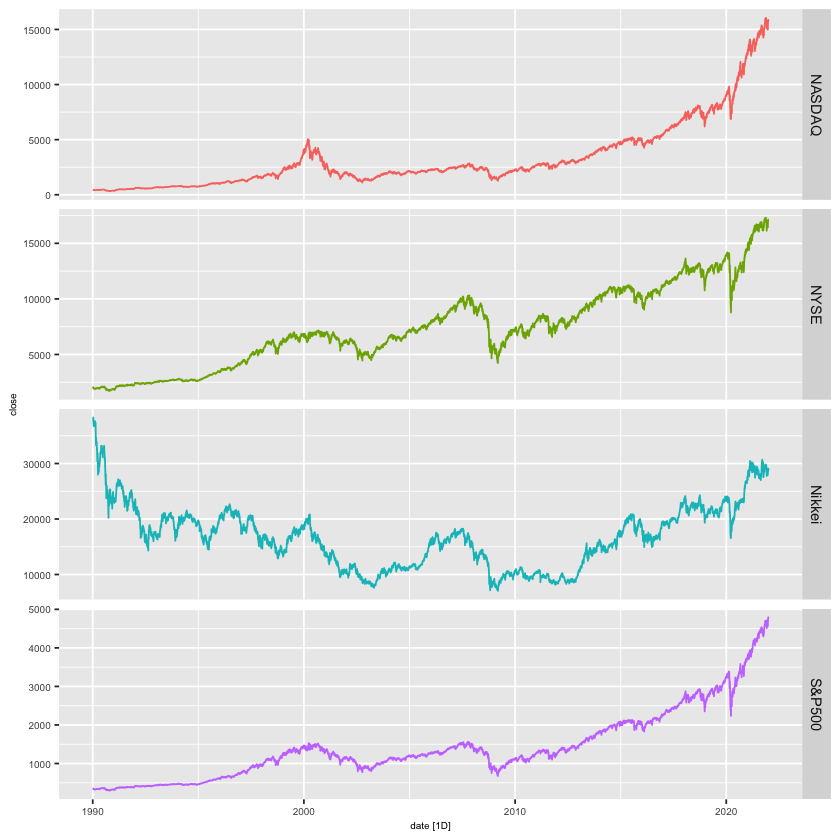

In [24]:
stock %>% 
  autoplot(close)+facet_grid(vars(symbol), scale = "free_y")+
  theme(legend.position="none", axis.text=element_text(size=6),
        axis.title.x = element_text(size = 6), axis.title.y = element_text(size = 6))


`mutate_if()` ignored the following grouping variables:
• Column `symbol`


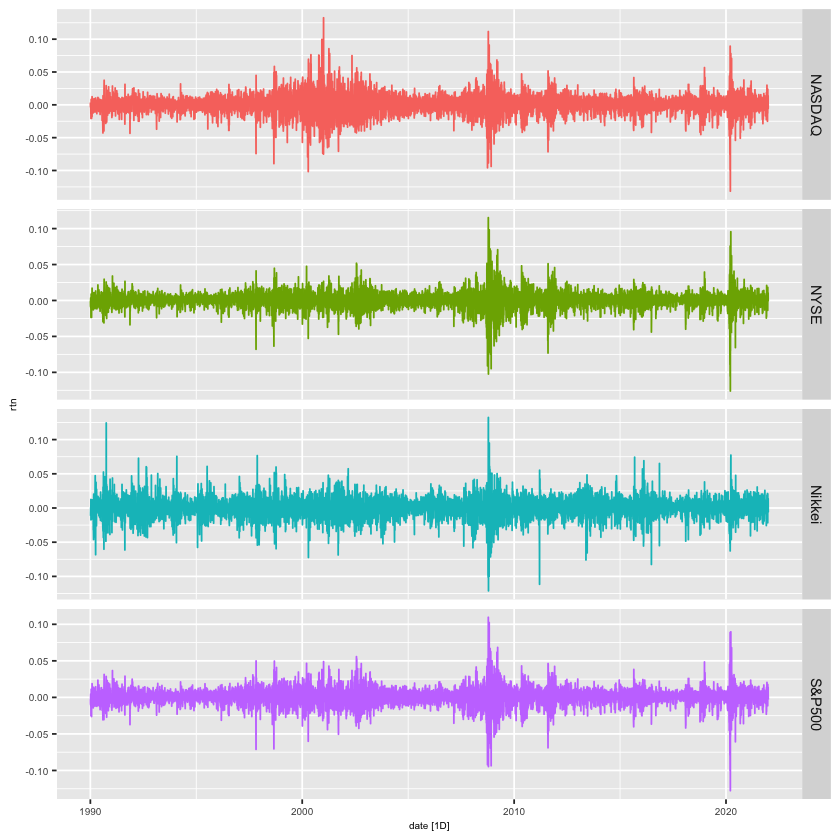

In [25]:
stock %>% 
  autoplot(rtn)+facet_grid(vars(symbol), scale = "free_y" )+
  theme(legend.position="none", axis.text=element_text(size=6),
        axis.title.x = element_text(size = 6), axis.title.y = element_text(size = 6))


In [28]:
sd(stock$rtn, na.rm = TRUE)

[1] 0.01305227

## Positive Equity Risk Premium
- The Equity Risk Premium is defined as
  - $ERP = E(r_t) − i_t$
- where $E(r_t)$ is the expected return from an investment in a market portfolio of stocks and it is the return from riskless investments (usually treasury bonds) for the same period.
We expect ERP > 0: A positive premium is required by finance theory, otherwise there is no incentive to accept additional risk from an investment in a market portfolio of stocks.

Dimson, E., Marsh, P., & Staunton, M. (2003). Global evidence on the equity risk premium. Journal of Applied Corporate Finance, 15(4), 27-38.

## Standard Deviations Depending on the Assets
Standard deviations can be ranked as follows:
- currencies and bonds have the least variability;
- equity indices;
- individual stocks;
- digital currencies
- Standard deviations tend to increase as the firm
size decreases.

## Asymmetric Distributions
- Let
Skew = $\frac{E[(r_t − E(r_t))^3]}{\sigma^3}$
 We use the Skewness as a measure of the distribution’s asymmetry:
- The distribution is Right-skewed if Skew > 0
- The distribution is Left-skewed if Skew < 0
- The distribution is symmetric if Skew = 0
- 
Since Skew is unknown, we use the corresponding
empirical moment (plim $\hat{Skew} = Skew$, under certain conditions)
- $\hat{skew} = \frac{T^{-1} \sum{(r_t - \bar{r})^3}}{\hat{\sigma}^3}$

- To test H_0 : Skew = 0 we use the result:
  - Z1= $\sqrt{T}\frac{\hat{sqew}}{\sqrt{6}} \rightarrow N(0,1)$
   - assuming that {r_t} is a sequence of i.i.d. normal random variables


In [31]:
library(timeSeries)
stock %>%
  features(rtn,list(skew =  timeSeries::colSkewness, 
                    n = ~length(.))) %>%
             mutate(skew_stat =  sqrt(n)*skew/sqrt(6), 
                    p_val_skew_stat = 2*(1-pnorm(abs(skew_stat))))
             


Loading required package: timeDate


Attaching package: ‘timeDate’


The following objects are masked from ‘package:PerformanceAnalytics’:

    kurtosis, skewness



Attaching package: ‘timeSeries’


The following object is masked from ‘package:zoo’:

    time<-




symbol,skew,n,skew_stat,p_val_skew_stat
<chr>,<dbl>,<int>,<dbl>,<dbl>
NASDAQ,-0.2159809,8062,-7.917008,2.442491e-15
NYSE,-0.6047911,8062,-22.169259,0.000000e+00
Nikkei,-0.1683098,7648,-6.009077,1.865831e-09
S&P500,-0.4136450,8062,-15.162594,0.000000e+00


## Heavy-tailed distributions
- This is one of the most important stylized facts because it is pervasive across many financial returns.
- In a heavy-tailed distribution the likelihood that one encounters significant deviations (extreme values) from the mean or the median is much greater than in the case of the normal distribution. This occurs because in the heavy-tailed distributions the probability in the tails is greater than in the normal distribution.
- Examples of extreme values in stock markets: the Wall Street Crash of 1929, Black Monday (1987), Dot-com bubble, sub-prime financial crisis, 2010 crash crash, the 2020 stock market crash.
- These extreme values are not restricted to dramatic events. They also include strong variations that occur frequently due to a numerous factors: a data release or central bank announcement; Interest rate changes; Political developments such a change in political leadership; Company news such as a new product; etc. 
- An increasing variety of outcomes is being identified to have heavy tail distributions, including income distributions, financial returns, insurance payouts, reference links on the web, etc.
- There are several definitions of heavy-tailed distributions (e.g. heavy-tailed distributions are probability distributions whose tails are not exponentially bounded), but we are going to use a simple one
- $ Kurt = \frac{E[(r_t − E(r_t))^4]}{\sigma^4} > 3$
- More on Kurtosis:
  - Kurt < 3 Platykurtic
  - Kurt = 3 Normal
  - Kurt > 3 Leptokurtic (heavy-tailed distribution)
- For example if $r \rightarrow t(ν)$
  then (it can be proved):
  - $Kurt=3 + \frac{6}{v-4} ; v>4$
- Since Kurt is unknown we use the corresponding empirical moment:

- $\hat{Kurt} = \frac{T^-1\sum{(r_t - \bar{r})^4}}{\hat{\sigma^4}}$

- To test H_0 : Kurtt = 3 we use the result:
  - Z2= $\sqrt{T}\frac{\hat{sqew} - 3}{\sqrt{24}} \rightarrow N(0,1)$
   - assuming that {r_t} is a sequence of i.i.d. normal random variables

In [37]:
stock %>%
  features(rtn,list(skew =  timeSeries::colSkewness, 
                    n = ~length(.))) %>% 
             mutate(skew_stat =  sqrt(n)*skew/sqrt(6), 
                    p_val_skew_stat = 2*(1-pnorm(abs(skew_stat)))) #%>% 
  #kbl(booktabs = TRUE)

symbol,skew,n,skew_stat,p_val_skew_stat
<chr>,<dbl>,<int>,<dbl>,<dbl>
NASDAQ,-0.2159809,8062,-7.917008,2.442491e-15
NYSE,-0.6047911,8062,-22.169259,0.000000e+00
Nikkei,-0.1683098,7648,-6.009077,1.865831e-09
S&P500,-0.4136450,8062,-15.162594,0.000000e+00


In [39]:
stock %>%
  features(rtn,list(kurt =  timeSeries::colKurtosis, 
                    n = ~length(.))) %>% 
             mutate(kurt = kurt +3, 
                    kurt_stat =  sqrt(n)*(kurt - 3)/sqrt(24), 
                    p_val_kurt_stat = 2*(1-pnorm(abs(kurt_stat))))
             

symbol,kurt,n,kurt_stat,p_val_kurt_stat
<chr>,<dbl>,<int>,<dbl>,<dbl>
NASDAQ,10.182122,8062,131.6341,0
NYSE,16.657828,8062,250.3211,0
Nikkei,8.669417,7648,101.2061,0
S&P500,14.382706,8062,208.6226,0


In [40]:
stock %>%
  features(rtn,list(kurt =  timeSeries::colKurtosis, 
                    n = ~length(.))) %>% 
             mutate(kurt = kurt+3,
                    kurt_stat =  sqrt(n)*(kurt-3)/sqrt(24), 
                    p_val_kurt_stat = 2*(1-pnorm(abs(kurt_stat)))) #%>% 
  #kbl(booktabs = TRUE)

symbol,kurt,n,kurt_stat,p_val_kurt_stat
<chr>,<dbl>,<int>,<dbl>,<dbl>
NASDAQ,10.182122,8062,131.6341,0
NYSE,16.657828,8062,250.3211,0
Nikkei,8.669417,7648,101.2061,0
S&P500,14.382706,8062,208.6226,0


## Aggregational Gaussianity
- As one decreases the frequency over which returns are calculated, their distribution looks more and more like a normal distribution.
- In particular, the shape of the distribution is not the same at different time frequencies.
- The table below shows how the kurtosis and the value of the JB statistic decrease as the time frequency decreases.
- Daily, and monthly returns all have a JB p-value that rejects normality; however, not necessarily for quarterly returns.

In [42]:
feat_normal <- function(x){
  n <- length(x)
  kurt <- sum(((x-mean(x))/sd(x))^4)/n
  skew <- sum(((x-mean(x))/sd(x))^3)/n
  JB <- (n/6)*(skew^2) + (n/24)*((kurt-3)^2)
  pval_JB <- 1-pchisq(JB, df = 2)
  c(kurt = kurt, skew = skew, 
    JB = JB, pval_JB = pval_JB) 
}

register_feature(feat_normal, 
                 tags = c("simple", "summary"))

stock %>% features(rtn,feat_normal)


symbol,kurt,skew,JB,pval_JB
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NASDAQ,10.182122,-0.2159809,17390.23,0
NYSE,16.657828,-0.6047911,63152.12,0
Nikkei,8.669417,-0.1683098,10278.78,0
S&P500,14.382706,-0.4136450,43753.28,0


## Exercise 1
- can use readr to read in rectangular datasets
- better to read csv files
- get used to usig summarise for mean, sum etc
- 

In [34]:
tourism_df = read_excel('/Users/dhruvpandit/Documents/GitHub/ISEG_AEF/Financial Time Series/tourism.xlsx') %>% mutate(Quarter = yearquarter(Quarter)) %>% as_tsibble(index = Quarter, key = c(Region, State, Purpose))
#tourism_df  as_tsibble(tourism_df)

In [47]:
tourism_df %>% features(Trips, list(avg = mean)) %>% arrange(desc(avg)) # exercies 4

Region,State,Purpose,avg
<chr>,<chr>,<chr>,<dbl>
Sydney,New South Wales,Visiting,747.2700
Melbourne,Victoria,Visiting,618.8975
Sydney,New South Wales,Business,602.0439
North Coast NSW,New South Wales,Holiday,587.8966
Sydney,New South Wales,Holiday,550.3269
Gold Coast,Queensland,Holiday,528.3399
Melbourne,Victoria,Holiday,507.2823
South Coast,New South Wales,Holiday,495.0589
Brisbane,Queensland,Visiting,492.8061


In [49]:
tourism_df %>% group_by(State) %>% summarise(Trips  = sum(Trips)) %>% as_tsibble(index = Quarter, key = c(State, Trips))

State,Quarter,Trips
<chr>,<qtr>,<dbl>
ACT,2003 Q1,378.3360
ACT,1999 Q1,378.5728
ACT,2011 Q1,380.9004
ACT,2001 Q1,390.5585
ACT,2009 Q2,396.7498
ACT,2009 Q3,410.1553
ACT,1998 Q2,416.0256
ACT,2005 Q4,423.1985
ACT,2004 Q3,423.8953


### Calendar Effects
- Calendar effects occur when returns and/or volatility varies with the calendar.
- For example, if a security has a higher return and/or volatility on Mondays, we will have a calendar effect.
- Some of the most popular calendar effects are the following:
  - Day of the week effect: the returns vary across theweek, and due to weekends, stock prices tend to decrease on Mondays.
  - Turn-of-the-month effect: stock prices tend to riseon the last trading day of the month and the first three trading days of the next month.
  - Turn-of-the-year effect: trading volume and higher stock prices tend to increase in the last week of December and the first two weeks of January.
  - January effect: Securities’ prices increase in the month of January more than in any other month.
- To test the day of the week effect estimate :
  - $r_t = c + \delta_1 tues_t + delta_2 wed_t + delta_3 thu_t + delta_4 fri_t +u_t$ where the variables are dummy
  - The testing hypothesis is :
    - $H_0 : \delta_1 = ... \delta_4 = 0$ against $H_1 : not 0$
    - In the presence of heteroskedasticity, the usual F test is invalid. A solution is to use HAC (heteroskedasticity and autocorrelation consistent) standard errors. So account for heterosekd and autocorrelation

sto

In [52]:
library(tidyverse)
library(fpp3)
library(tidyquant)
library(sandwich)
library(lmtest)
library(GGally)
library(kableExtra)


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




ERROR: Error in mutate(., wkday = weekdays(date)): object 'stock' not found


In [66]:
stock %>% mutate(wkday  = weekdays(date)) %>% model(TSLM(rtn~1+wkday)) %>% tidy() 

symbol,.model,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NASDAQ,TSLM(rtn ~ 1 + wkday),(Intercept),2.461605e-04,0.0003618657,0.6802538,0.4963633
NASDAQ,TSLM(rtn ~ 1 + wkday),wkdayMonday,-4.139813e-04,0.0005190952,-0.7975055,0.4251810
NASDAQ,TSLM(rtn ~ 1 + wkday),wkdayThursday,3.463501e-04,0.0005107302,0.6781468,0.4976981
NASDAQ,TSLM(rtn ~ 1 + wkday),wkdayTuesday,2.623050e-04,0.0005085702,0.5157694,0.6060296
NASDAQ,TSLM(rtn ~ 1 + wkday),wkdayWednesday,7.170115e-04,0.0005085702,1.4098573,0.1586204
NYSE,TSLM(rtn ~ 1 + wkday),(Intercept),2.756346e-04,0.0002773421,0.9938431,0.3203291
NYSE,TSLM(rtn ~ 1 + wkday),wkdayMonday,-1.947690e-04,0.0003978464,-0.4895582,0.6244599
NYSE,TSLM(rtn ~ 1 + wkday),wkdayThursday,-1.890632e-04,0.0003914353,-0.4829999,0.6291090
NYSE,TSLM(rtn ~ 1 + wkday),wkdayTuesday,2.335440e-04,0.0003897798,0.5991690,0.5490771


### ACF and Correlogram
- Ljung-Box statistic: tests H0 : ρ1 = ρ2 = ...ρK = 0 against H1 :ρ1 ̸=0∨ρ2 ̸=0∨...∨ρK ̸=0 with the statistic:

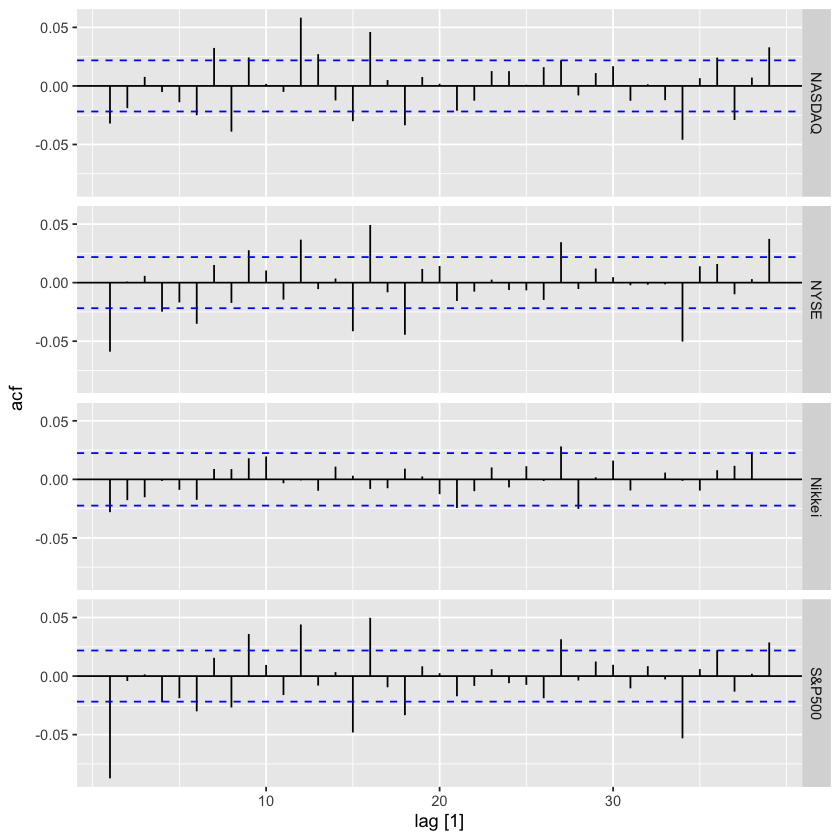

In [77]:
stock %>% update_tsibble(index = trading_day) %>% ACF(rtn) %>% autoplot()

In [78]:
stock %>% features(rtn, list(unitroot_kpss, unitroot_pp))

symbol,kpss_stat,kpss_pvalue,pp_stat,pp_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NASDAQ,0.1229657,0.10000000,-92.83944,0.01
NYSE,0.0636456,0.10000000,-95.52247,0.01
Nikkei,0.4896633,0.04399476,-90.03981,0.01
S&P500,0.1193844,0.10000000,-98.57851,0.01


`mutate_if()` ignored the following grouping variables:
• Column `symbol`


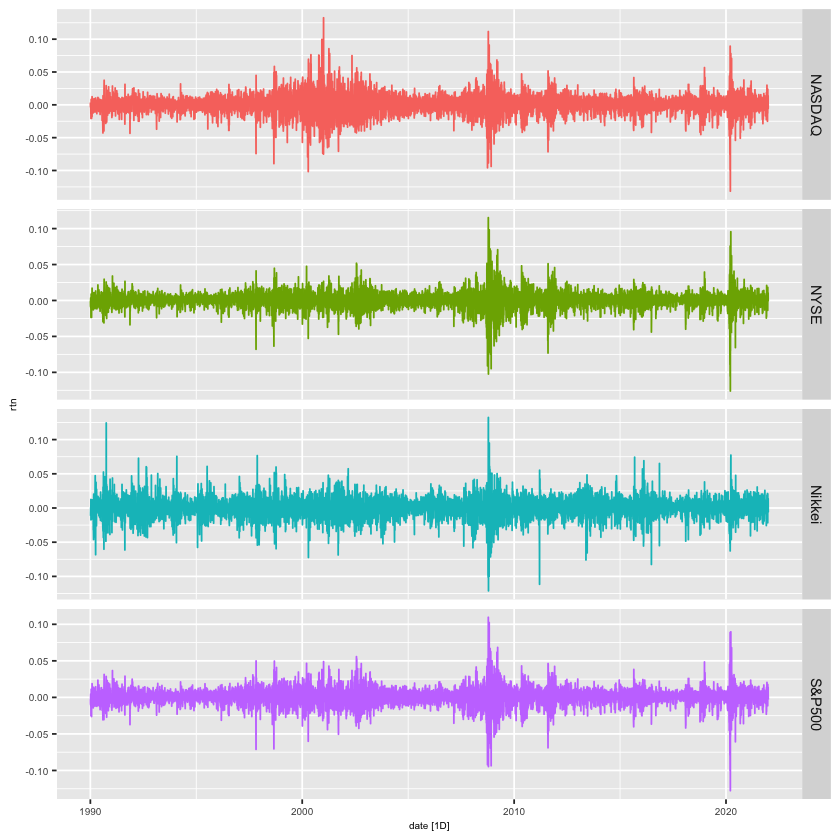

In [80]:
stock %>% 
  autoplot(rtn)+facet_grid(vars(symbol), scale = "free_y" )+
  theme(legend.position="none", axis.text=element_text(size=6),
        axis.title.x = element_text(size = 6), axis.title.y = element_text(size = 6))


### Strong temporal dependence of volatility
- Volatility is a latent variable (not directly measured).
- We use |rt| or $r_t^2$ as initial proxies for volatility using the reasoning: 
  - $Var(r_t) = E(r_t^2) − E(r_t)^2$ where the latter is close to 0
- Absolute or squared returns usually display a small 1st order SAC value but significant and slowly decaying and significant SACF thereafter.
- If you have intra daily data you could have data regarding volatility during the day (could plot that get an understanding of the volatility at each step)
- 

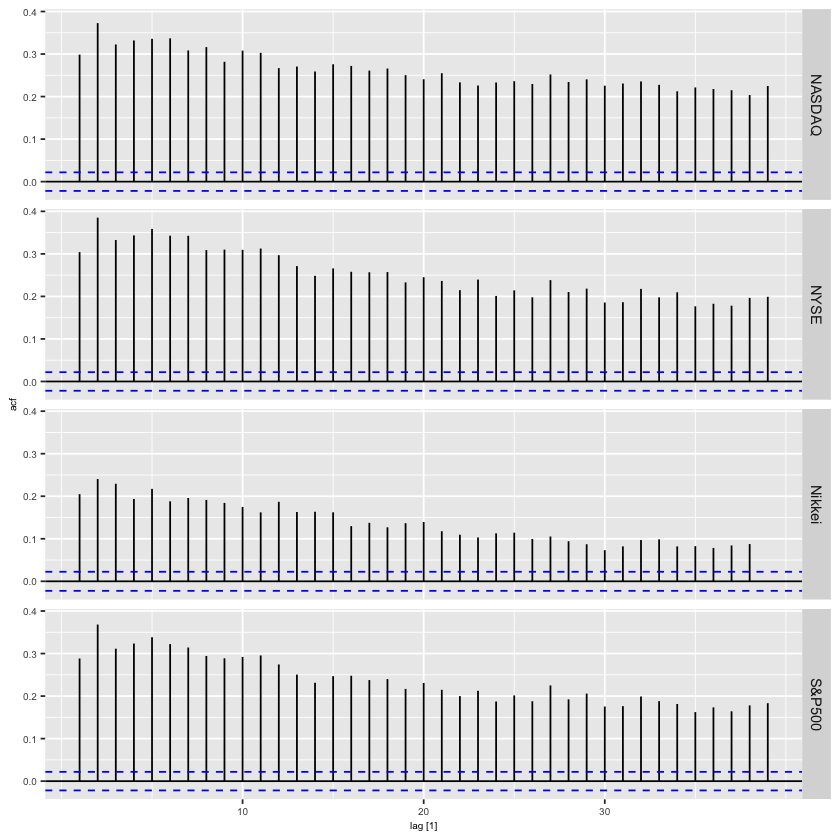

In [81]:
stock %>% update_tsibble(index = trading_day) %>% ACF(abs(rtn)) %>% 
  autoplot()+
  theme(legend.position="none", axis.text=element_text(size=6),
        axis.title.x = element_text(size = 6), axis.title.y = element_text(size = 6))


## Leverage effects
- Negative price movements (negative shocks) have a higher impact on volatility than positive surprises (positive shocks).
- This phenomenon is known as leverage effect following Black (1976).
- The fall of asset prices increases the leverage of the firm which has incentives to take riskier decisions and, consequently, volatility tends to be higher.
- A simple and naive way to explore the possible existence of this effect is using Corr(rt−1, |rt|) or Corr(rt−1, rt2).
- We expect Corr(rt−1, |rt|) < 0 or Corr(rt−1, rt2) < 0

In [ ]:
stock

In [86]:
stock %>% 
  as_tibble() %>% 
  group_by(symbol) %>% 
  summarise(corr = cor(rtn^2,lag(rtn),use='complete.obs'))


symbol,corr
<chr>,<dbl>
NASDAQ,-0.11164317
NYSE,-0.10127451
Nikkei,-0.08937118
S&P500,-0.10304193


## Comovements of Returns and Volatility
- Economic globalization and Internet communication have accelerated the integration of world financial markets.
- Price movements in one market can spread easily and instantly to another market.
- When analyzing two or more financial series of returns over time, we find co-movements between returns or volatilities
- Big movements in one market tend to be matched by big movements in another market either in terms of returns and volatility


Warning message:
“Removed 242 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 242 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 898 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 242 rows containing missing values”
Warning message:
“Removed 242 rows containing missing values (geom_point).”
Warning message:
“Removed 242 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 898 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 242 rows containing missing values”
Warning message:
“Removed 898 rows containing missing values (geom_point).”
Warning message:
“Removed 898 rows c

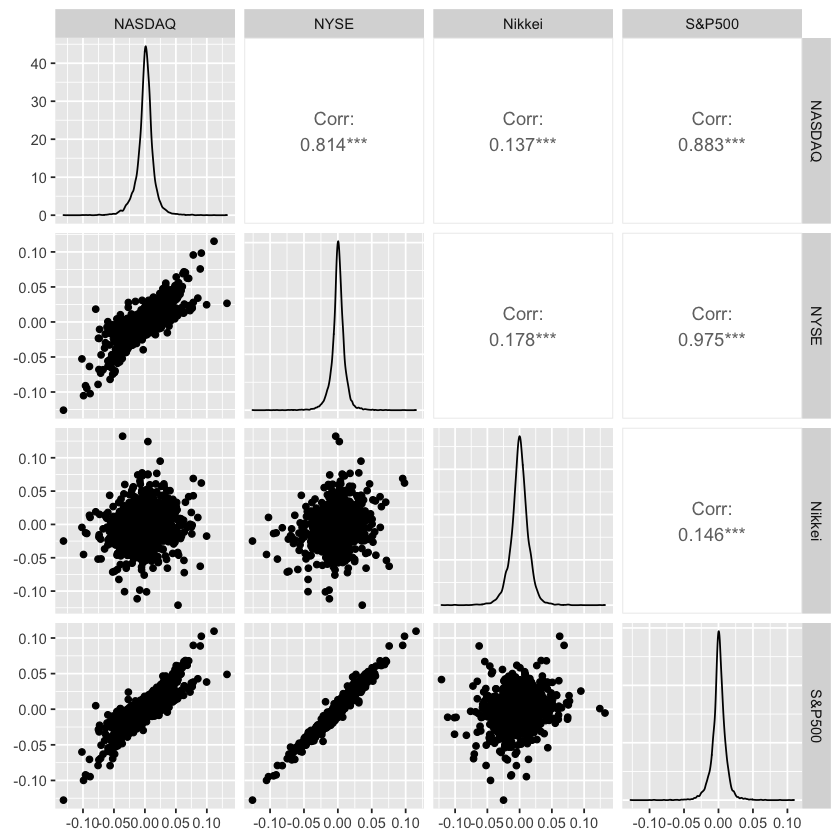

In [87]:
stock %>% select(symbol,date,rtn) %>% 
  pivot_wider(values_from = rtn, names_from = symbol)%>% 
  GGally::ggpairs(2:5)

Warning message:
“Removed 242 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 242 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 898 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 242 rows containing missing values”
Warning message:
“Removed 242 rows containing missing values (geom_point).”
Warning message:
“Removed 242 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 898 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 242 rows containing missing values”
Warning message:
“Removed 898 rows containing missing values (geom_point).”
Warning message:
“Removed 898 rows c

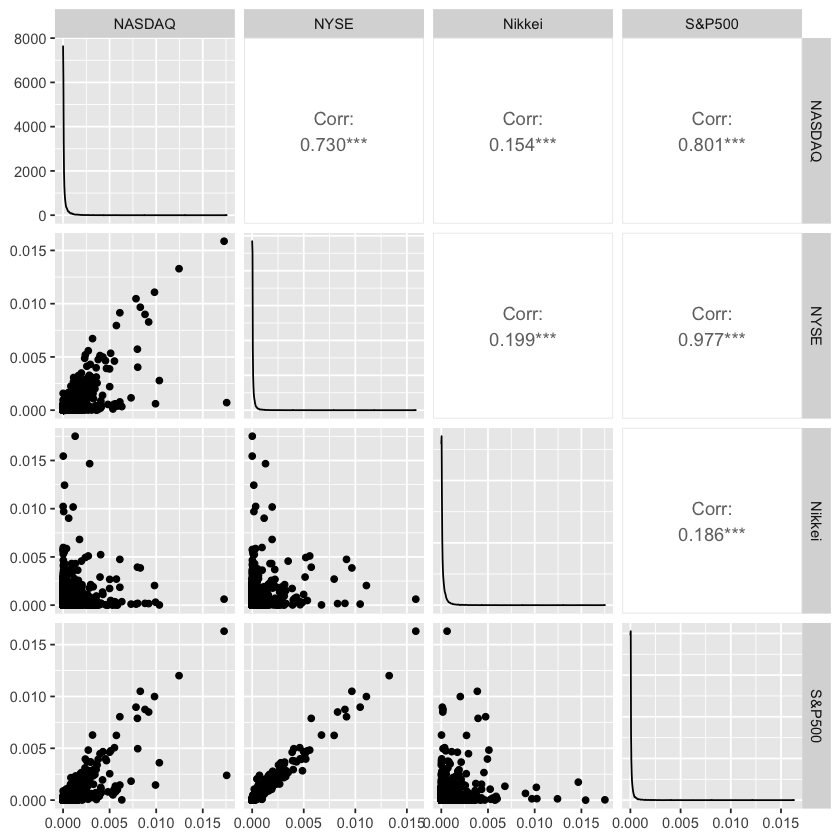

In [88]:
stock %>% mutate(rtn2 = rtn^2) %>% select(symbol,date,rtn2) %>% 
  pivot_wider(values_from = rtn2, names_from = symbol)%>% 
  GGally::ggpairs(2:5)
